In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%reload_ext version_information
np.__version__, pd.__version__

('1.16.4', '0.24.2')

In [2]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
import os
from urllib.request import urlretrieve
if not os.path.isfile('fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz',filename = 'fishing.npz')
d = np.load('fishing.npz')
Xt = d['Xt'] #"livebait","camper","persons","child"
Xte = d['Xte']
yt = d['yt']
yte = d['yte']
pd.DataFrame(Xt[0:2])

,0,1,2,3
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0


<h3>a) Do a linear regression by creating a design matrix with the intercept term and use the fomulae given in the lecture to determine the coefficients on the training set.</h3>

In [3]:
d = {'livebait': Xt[:,0], 'camper': Xt[:,1], 'persons': Xt[:,2], 'child': Xt[:,3]}
df = pd.DataFrame(data=d)
df.insert(0, 'Intercept',np.ones((np.shape(df)[0],1)))

In [4]:
df.head()

,Intercept,livebait,camper,persons,child
0,1.0,1.0,0.0,4.0,0.0
1,1.0,1.0,1.0,2.0,0.0
2,1.0,1.0,1.0,3.0,0.0
3,1.0,1.0,1.0,3.0,2.0
4,1.0,1.0,1.0,4.0,1.0


In [5]:
# Geht einfacher, ohne den Zwischenschritt über pandas, mit np.concatenate, aber so ist das anschaulicher
xt = np.asmatrix(df)

In [6]:
N = yt.shape[0]  #200
yt.shape, xt.shape

((200,), (200, 5))

In [7]:
w = np.ones((xt.shape[1])) #Setting w = 1

In [8]:
XTX = np.matmul(xt.T,xt)
XTXI = np.linalg.inv(XTX)
XTXIXT = np.matmul(XTXI, xt.T)
w = np.matmul(XTXIXT,yt)
w

matrix([[-8.49222821,  2.4822138 ,  2.95430727,  4.64953914, -5.47160051]])

<h3>b) Repeat a) but this time with <code>LinearRegression</code> from <code>sklearn.linear_model</code></h3>

In [9]:
from sklearn.linear_model import LinearRegression
model_skl = LinearRegression(fit_intercept=False) #We have an extended X
model_skl.fit(xt,yt)
model_skl.coef_

array([-8.49222821,  2.4822138 ,  2.95430727,  4.64953914, -5.47160051])

Result: array([-8.49222821, 2.4822138 , 2.95430727, 4.64953914, -5.47160051]) Don't forget the intercept, you should have 5 numbers!

<h3>c) Determine the Root Mean Square Error (RMSE) and the average negative log-likelihood (NLL) on the testset. For NLL we assume that the conditional probability distrubution (CPD) $p(y|x)$ is given by the density of a Gaussian with constant variance $\sigma^2$. Estimate $\sigma^2$ using the variance of the residuals. Use the variance estimation with $1/N$.</h3>

In [10]:
y = np.matrix(yte).T
w = w.T
inter = np.ones((np.shape(Xte)[0],1))
xte = np.concatenate((inter, Xte), axis = 1)

In [17]:
y_pred = np.matmul(xte,w)


RMSE = np.sqrt(np.mean(np.power((y_pred - y),2)))

In [19]:
resid = y_pred - y
sigma = np.power(resid, 2)
sigma = np.sum(sigma)
sigma = sigma/y_pred.shape[0]
#sigma

In [20]:
#np.random.normal(np.mean(y_pred), sigma)
nll_list = []
for i in range(1000):
    nll = 0
    for yi in y_pred:
        nll += np.log(abs(np.random.normal(yi, sigma)))
    nll = nll * (1/y_pred.shape[0])
    nll_list.append(nll[0][0])
#np.mean(nll_list)

In [21]:
print('RMSE:', RMSE, 'sigma: ', sigma, 'NLL: ', np.mean(nll_list))

RMSE: 8.588126386734231 sigma:  73.75591483452077 NLL:  3.6675596025876773


Result: $ RMSE \approx 8.58812$, $\hat \sigma^2 \approx 73.7559$, $\tt{NLL} \approx 3.569$

<h3>d) For the testset: plot the predicted mean number of fish caught ($\mu$) against observed number of fish caught. Further include the 2.5 and 97.5 precentile of p(y|x), the conditional predictive distribution (CPD) of $y$ for a given $x$. Why is a Gaussian not ideal for that kind of data?</h3>

(3.584986890619827, 3.06)

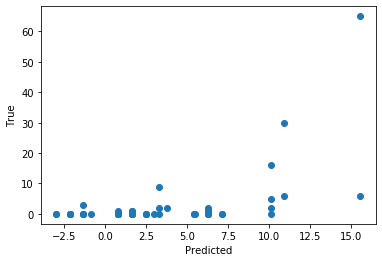

In [14]:
plt.scatter([y_pred[:,0]], [y[:,0]])
plt.xlabel('Predicted')
plt.ylabel('True')


In [39]:
perc_low = np.asarray(y_pred - 1.96 * np.sqrt(sigma))
perc_top = np.asarray(y_pred + 1.96 * np.sqrt(sigma))

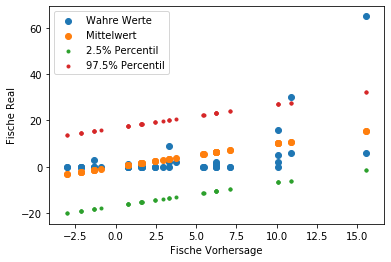

In [41]:
plot = plt.figure()
ax = plot.add_subplot(111)
ax.scatter([y_pred[:,0]], [y[:,0]], marker="o", label="Wahre Werte")
plt.xlabel("Fische Vorhersage")
plt.ylabel("Fische Real")
ax.scatter([y_pred[:,0]], [y_pred[:,0]], marker="o", label="Mittelwert")
ax.scatter([y_pred[:,0]], perc_low, marker=".", label="2.5% Percentil")
ax.scatter([y_pred[:,0]], perc_top, marker=".", label="97.5% Percentil")
ax.legend()

Hint: For the Gaussian the 2.5% and the 97.5% percentile is approximatiy given by $\mu \pm 1.96*\sigma$

<b>Es gibt nur ganze positive Zahlen für die Fische. Deswegen ist Gauss nicht optimal.</b>

<h3>e) This data is count data. Count data has only positive values and also the distribution is discrete. You cannot catch 0.5 fish and that the CPD has probability density > 0 on negative number of fish is wrong too. A Gaussian as a CPD is therefore not ideal.

Now use a Poissonian as CPD. If we assume a Poissonian then the probability to catch $k$ fish is given by$$
  p(k) = \exp(-\mu) \frac{\mu^k}{k!}
$$

and the NLL is thus by:

$$
 log(p(k)) = -\mu  + k \cdot \log(\mu) - log(k!)
$$
with $\mu$ being the expectation. In our case the average number of fish expected.

In the case of the probabilistic interpretation of the linear regression, $y_i$ for a given $x_i$ is distributed like a Gaussian. The paramter $\mu_i$ from $N(\mu_i,\sigma^2)$ has been determined from $x_i$ via $\mu_i= \beta^T \cdot x_i$ by minimizing the NLL.

A small additional detail: For the Poissonian case, $\mu_i$ needs to be positive. We therefore do not use $\beta^T \cdot x_i$ directly but "pipe it through" an exponential first to make it positive and thus link $\mu_i=exp(\beta^T \cdot x_i)$ to the data.

Use a gradient descent approach on the NLL to find the solution for the parameters. Calculate the RMSE and the NLL on the test set and compare with c).</h3>

In [63]:
from scipy.special import factorial
from numpy import isinf


def gradient(Xd, yt, w):  #Gradientenabstieg
    scores = np.exp(Xd @ w)  #If both a and b are 2-D arrays, it is matrix multiplication, but using matmul or a @ b is preferred.
    return -Xd.T @ (yt - scores) / 200


def log_likelihood(Xd, yt, w):  #Likelyhood

    mu = np.exp(Xd @ w)  #Wd Design matrix, w gewichte
    ret = np.zeros_like(mu)

    for i in range(ret.shape[0]):
        ret[i] = mu[i] - yt[i] * np.log(mu[i]) + np.log(
            1.0 * np.math.factorial(yt[i]))  #Formel
    return np.mean(ret)


def logistic_regression(Xd, yt, num_steps, learning_rate):

    weights = np.zeros(Xd.shape[1])
    weights = np.expand_dims(weights, 1)

    for step in range(num_steps):
        grad = gradient(Xd, yt, weights)

        weights -= learning_rate * grad

        # Print log-likelihood every so often
        #if step % 500 == 0:
            #print('Epoch {}\t with NLL: '.format(step),
                #  log_likelihood(Xd, yt, weights))

    return weights

In [80]:
print('Log Likelihood für den Test Wert Theta: ', log_likelihood(xt, yt, np.array([1, 1, 1, 1, 1])))
print('Gradient für den Test Wert Theta: \t', gradient(xt, yt, np.expand_dims([1, 1, 1, 1, 1], 1)).T[0])

Log Likelihood für den Test Wert Theta:  1494.3472942607975
Gradient für den Test Wert Theta: 	 [[1515.96804305 1402.14474131 1170.07247951 5698.03224653 3255.09389229]]


Hint: On the trainingset for the parameter values (1,1,1,1,1) the NLL should be approx 1508 and the gradient (1518.61, 1403.99, 1171.02, 5701.91, 3258.7). For the NLL a good learning rate would be 0.001 and training should be done for at least 5000 epochs.

In [99]:
lr = 0.001
n_iter = 5000
ytt = np.matrix(yt).T
print(xt.shape, ytt.shape)
theta = logistic_regression(xt, ytt, n_iter, lr)
#y_pred = np.exp(np.matmul(xte,w))
y_pred = np.exp(xte @ theta)

(200, 5) (200, 1)


<h3>f) Do the same plot as in d) but this time with a Poisson CPD. Hint you can use scipy.stats.poisson to calculate the percentiles.</h3>

In [53]:
from scipy.stats import poisson
low_percentile = []
top_percentile = []
for i in range(0, len(xte)):
    low_percentile.append(poisson.ppf(0.025, y_pred[i]))
    top_percentile.append(poisson.ppf(0.975, y_pred[i]))

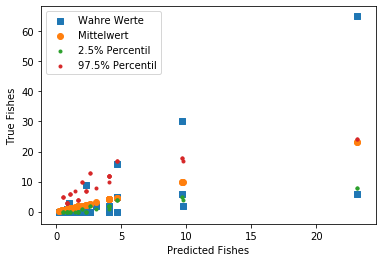

In [100]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter([y_pred[:,0]], [y[:,0]], marker="s", label="Wahre Werte")
plt.xlabel('Predicted Fishes')
plt.ylabel('True Fishes')
ax1.scatter([y_pred[:,0]], [y_pred[:,0]], marker="o", label="Mittelwert")
ax1.scatter([y_pred[:,0]], low_percentile, marker='.', label="2.5% Percentil")
ax1.scatter([y_pred[:,0]], top_percentile, marker='.', label="97.5% Percentil")
ax1.legend()

In [15]:
%version_information numpy, pandas

Software versions
Python 3.7.3 64bit [MSC v.1915 64 bit (AMD64)]
IPython 7.6.1
OS Windows 10 10.0.18362 SP0
numpy 1.16.4
pandas 0.24.2
Mon Nov 18 09:14:42 2019 Mitteleuropäische Zeit